Geração 1 - Melhor Fitness: 8.631409
Geração 2 - Melhor Fitness: 8.631409
Geração 3 - Melhor Fitness: 8.631409
Geração 4 - Melhor Fitness: 8.631409
Geração 5 - Melhor Fitness: 8.631409
Geração 6 - Melhor Fitness: 8.631409
Geração 7 - Melhor Fitness: 8.631409
Geração 8 - Melhor Fitness: 8.631409
Geração 9 - Melhor Fitness: 24.996061
Geração 10 - Melhor Fitness: 24.996061
Geração 11 - Melhor Fitness: 24.996061
Geração 12 - Melhor Fitness: 24.996061
Geração 13 - Melhor Fitness: 24.996061
Geração 14 - Melhor Fitness: 24.996061
Geração 15 - Melhor Fitness: 24.996061
Geração 16 - Melhor Fitness: 24.996061
Geração 17 - Melhor Fitness: 24.996061
Geração 18 - Melhor Fitness: 24.996061
Geração 19 - Melhor Fitness: 24.996061
Geração 20 - Melhor Fitness: 24.996061
Geração 21 - Melhor Fitness: 24.996061
Geração 22 - Melhor Fitness: 24.996061
Geração 23 - Melhor Fitness: 24.996061
Geração 24 - Melhor Fitness: 24.996061
Geração 25 - Melhor Fitness: 24.996061
Geração 26 - Melhor Fitness: 24.996061
Ger

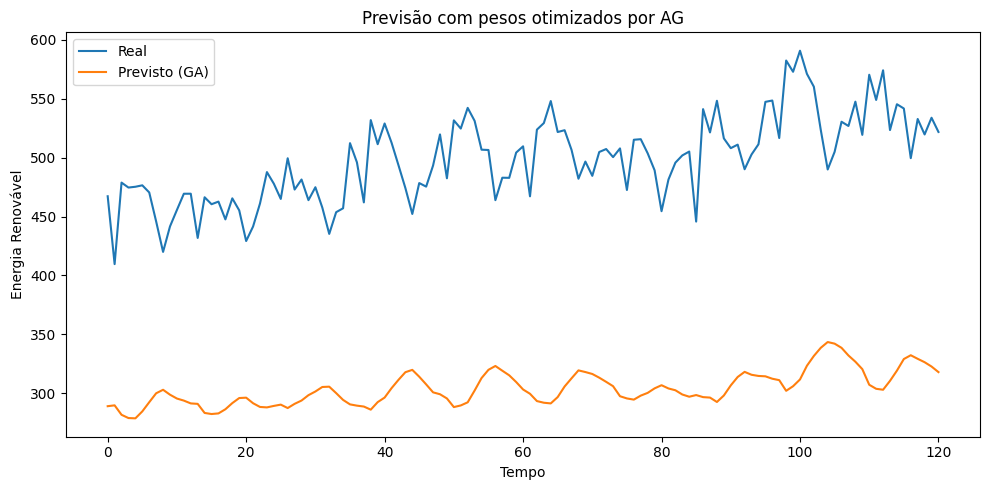

In [8]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
import pygad
import pygad.kerasga

# Reprodutibilidade
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Carregamento e normalização dos dados
df = pd.read_csv('data_per_month.csv')
df = df['Total Renewable Energy']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Criação das sequências temporais
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(data_scaled, time_steps)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 🔧 Modelo LSTM sem compilação
model = Sequential([
    Input(shape=(time_steps,1)),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Integração com PyGAD
keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=10)

# 🎯 Função de fitness
def fitness_func(ga_instance, solution, sol_idx):
    model_weights = pygad.kerasga.model_weights_as_matrix(model, solution)
    model.set_weights(model_weights)
    predictions = model.predict(X_train, verbose=0)
    loss = np.mean((predictions - y_train) ** 2)
    return 1.0 / (loss + 1e-8)

# ⚙️ Configuração do algoritmo genético
ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    initial_population=keras_ga.population_weights,
    fitness_func=fitness_func,
    mutation_type="random",
    mutation_percent_genes=10,
    crossover_type="two_points",
    on_generation=lambda ga: print(f"Geração {ga.generations_completed} - Melhor Fitness: {ga.best_solution()[1]:.6f}")
)

# 🚀 Executar a otimização
ga_instance.run()

# 🧠 Melhor solução → aplicar na rede
solution, solution_fitness, _ = ga_instance.best_solution()
weights_best = pygad.kerasga.model_weights_as_matrix(model, solution)
model.set_weights(weights_best)

# 🧪 Previsões no conjunto de teste
predictions = model.predict(X_test, verbose=0)

# 🔄 Reverter normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions)

# 📊 Métricas
mae = mean_absolute_error(y_test_inv, predictions_inv)
mse = mean_squared_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"\nMAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 📈 Plots
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Real")
plt.plot(predictions_inv, label="Previsto (GA)")
plt.title("Previsão com pesos otimizados por AG")
plt.xlabel("Tempo")
plt.ylabel("Energia Renovável")
plt.legend()
plt.tight_layout()
plt.show()
